In [1]:
import sys
sys.path.append('../')
import argparse
from dataset.get_dataset import getDataset
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

class args_struct:
    def __init__(self):
        self.dataroot = '../DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = False
        self.random_seed = 27
args = args_struct()
train_set, valid_set, test_set = getDataset(args, validate=args.validate)
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def get_dice_threshold(output, mask, threshold):
    """
    :param output: output shape per image, float, (0,1)
    :param mask: mask shape per image, float, (0,1)
    :param threshold: the threshold to binarize output and feature (0,1)
    :return: dice of threshold t
    """
    smooth = 1e-6

    zero = torch.zeros_like(output)
    one = torch.ones_like(output)
    output = torch.where(output > threshold, one, zero)
    mask = torch.where(mask > threshold, one, zero)
    output = output.view(-1)
    mask = mask.view(-1)
    intersection = (output * mask).sum()
    dice = (2. * intersection + smooth) / (output.sum() + mask.sum() + smooth)

    return dice
def get_soft_dice(outputs, masks):
    """
    :param outputs: B * output shape per image
    :param masks: B * mask shape per image
    :return: average dice of B items
    """
    dice_list = []
    for this_item in range(outputs.size(0)):
        output = outputs[this_item]
        mask = masks[this_item]
        dice_item_thres_list = []
        for thres in [0.1, 0.3, 0.5, 0.7, 0.9]:
            dice_item_thres = get_dice_threshold(output, mask, thres)
            dice_item_thres_list.append(dice_item_thres.data)
        dice_item_thres_mean = np.mean(dice_item_thres_list)
        dice_list.append(dice_item_thres_mean)

    return np.mean(dice_list)

#### Get model preds

In [4]:
from models.unet_le import UNetLE

In [5]:
class args_struct:
    def __init__(self):
        self.dataroot = '../DiscRegion'
        self.rater_num = 6
        self.img_width = 256
        self.img_height = 256
        self.dataset = 'RIGA'
        self.validate = True
        self.standardize = True
        self.random_seed = 27
        self.loss_func = 'bce'
        self.batch_size = 1
        self.gt_type_train = -1
        self.num_worker = 4

In [6]:
args = args_struct()

args.gt_type_train = -1
args.loss_func = 'bce' 
args.batch_size = 1
args.num_worker = 4
args.use_mix_label = False
args.standardize = True

In [7]:
from trainer.train_riga_unet_le import validate_riga_le
from loss_func.get_loss import get_loss_func

loss_func = get_loss_func(args)

In [8]:
import albumentations as A

In [40]:
transforms = None

transforms_50 = A.Compose([
    A.GaussNoise(p=0.5, var_limit=(50, 60)),
    A.Blur(p=0.5, blur_limit=(21, 21)),
    A.HueSaturationValue(p=0.5, hue_shift_limit=(20, 30))
], p=1)

transforms_100 = A.Compose([
    A.GaussNoise(p=1, var_limit=(50, 60)),
    A.Blur(p=1, blur_limit=(21, 21)),
    A.HueSaturationValue(p=1, hue_shift_limit=(20, 30))
], p=1)

In [41]:
args = args_struct()
args.standardize = False
train_set, valid_set, test_set = getDataset(args, validate=args.validate, transforms=None)

_, _, test_set_50 = getDataset(args, validate=args.validate, transforms=transforms_50)

_, _, test_set_100 = getDataset(args, validate=args.validate, transforms=transforms_100)

In [44]:
train_loader = DataLoader(test_set_100, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)

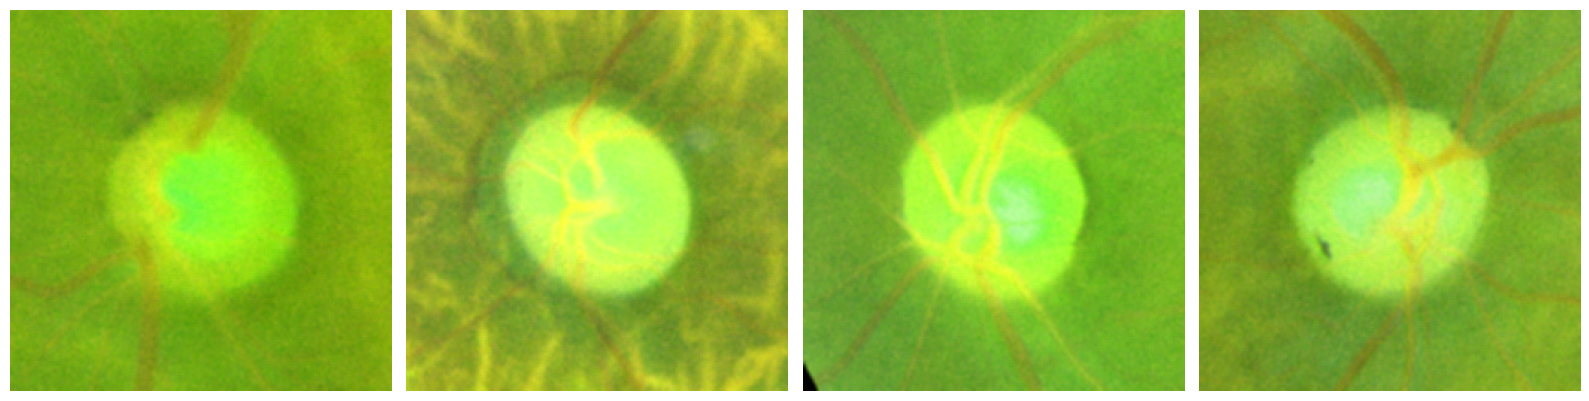

In [45]:
batch_data = next(iter(train_loader))

plt.figure(figsize=(16, 16))
for i,(img,mask) in enumerate(zip(batch_data['image'], batch_data['mask'])):
    img = ((img.permute(1,2,0))*255.0).numpy().astype(np.uint8)
    plt.subplot(2, 4, i+1)
    plt.imshow(img,vmin=0,vmax=255)
    # plt.imshow(mask[0], mask[2])[1].squeeze().numpy(), alpha=0.2, cmap='gray')
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=0.1)

plt.tight_layout()

In [46]:
args = args_struct()
args.standardize = True
train_set, valid_set, test_set = getDataset(args, validate=args.validate, transforms=None)

_, _, test_set_50 = getDataset(args, validate=args.validate, transforms=transforms_50)

_, _, test_set_100 = getDataset(args, validate=args.validate, transforms=transforms_100)

In [48]:
models = {
    'le': {
        'path': '/home/kudaibergen/projects/grader_soup/outputs_20.02/RIGA_gt_annots_train_majority_vote_UnetLE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    },
    'our': {
        'path': '/home/kudaibergen/projects/grader_soup/outputs_20.02/RIGA_gt_annots_train_majority_vote_UnetLE_LE_w0.3_decoder_heads_only_var_5_lbls_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop0/checkpoints/best_loss.pt'
    }} 

for key, value in models.items():
    skip_encoder = False if key == 'le' else True
    model = UNetLE(skip_encoder=skip_encoder)
    model.load_state_dict(torch.load(value['path'])['model'])
    models[key]['model'] = model        

cup_idx = 1
disc_idx = 0

In [85]:
def get_model_outputs(args, model, val_set, loss_function, skip_idx=None, get_inter_layer_agreements=False):
    model = model.cuda()
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    model.eval()

    outputs_model = []
    masks = []
    disc_dices = []
    cup_dices = []

    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            outputs = model({'image': imgs})

            mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
            gt_mask = mask_major_vote.cuda()

            outputs_sigmoid = []
            disc_dices_img = []
            cup_dices_img = []
            if skip_idx is not None:
                outputs = outputs[skip_idx:]

            for i, out in enumerate(outputs):
                out = torch.nn.functional.interpolate(out, size=mask[0].shape[2:])
                out = torch.sigmoid(out)
                outputs_sigmoid.append(out)

            if get_inter_layer_agreements:
                temp_disc = []
                temp_cup = []
                for i in range(len(outputs_sigmoid)):
                    for j in range(i+1, len(outputs_sigmoid)):        
                        val_soft_dice_disc = get_soft_dice(
                            outputs=outputs_sigmoid[i][:, 0, :, :].cpu(),
                            masks=outputs_sigmoid[j][:, 0, :, :].cpu()) * imgs.size(0)
                        val_soft_dice_cup = get_soft_dice(
                            outputs=outputs_sigmoid[i][:, 1, :, :].cpu(), 
                            masks=outputs_sigmoid[j][:, 1, :, :].cpu()) * imgs.size(0)
                        temp_disc.append(val_soft_dice_disc)
                        temp_cup.append(val_soft_dice_cup)

                disc_dices_img.append(temp_disc)
                cup_dices_img.append(temp_cup)
            else:
                for i in range(len(outputs_sigmoid) - 1):
                    val_soft_dice_disc = get_soft_dice(
                        outputs=outputs_sigmoid[i][:, 0, :, :].cpu(),
                        masks=outputs_sigmoid[i+1][:, 0, :, :].cpu()) * imgs.size(0)
                    val_soft_dice_cup = get_soft_dice(
                        outputs=outputs_sigmoid[i][:, 1, :, :].cpu(), 
                        masks=outputs_sigmoid[i+1][:, 1, :, :].cpu()) * imgs.size(0)
                    disc_dices_img.append(val_soft_dice_disc)
                    cup_dices_img.append(val_soft_dice_cup)

        disc_dices.append(disc_dices_img)
        cup_dices.append(cup_dices_img)
    return disc_dices, cup_dices

In [76]:
disc_threshold = 0.9
cup_threshold = 0.85

In [86]:
for key, val in models.items():
    skip_idx = None if key == 'le' else None
    disc_dices, cup_dices = get_model_outputs(args, val['model'], test_set, loss_func, skip_idx=skip_idx, 
                                              get_inter_layer_agreements=True)
    models[key]['dices'] = (disc_dices, cup_dices)

    disc_dices_50, cup_dices_50 = get_model_outputs(args, val['model'], test_set_50, loss_func, skip_idx=skip_idx,
                                                    get_inter_layer_agreements=True)
    models[key]['dices_50'] = (disc_dices_50, cup_dices_50)

    disc_dices_100, cup_dices_100 = get_model_outputs(args, val['model'], test_set_100, loss_func, skip_idx=skip_idx, 
                                                      get_inter_layer_agreements=True)
    models[key]['dices_100'] = (disc_dices_100, cup_dices_100)

### Get results for deep ensembles

In [99]:
from models.unet import UNet

checkpoints = [
    f'/home/kudaibergen/projects/grader_soup/outputs/RIGA_gt_annots_train_majority_vote_UnetDE_bce_pretrain0_validateTrue/bs16_lr5e-05_wd0.0_epoch200/loop{i}/checkpoints/best_loss.pt'
    for i in range(2, 8)
    ]

de_models = []
for chk in checkpoints:
    model = UNet()
    model.load_state_dict(torch.load(chk)['model'])
    model.eval()
    model.cuda()
    de_models.append(model)

def get_model_outputs_de(args, models, val_set):
    val_loader = DataLoader(val_set, batch_size=args.batch_size, shuffle=False, num_workers=args.num_worker, pin_memory=True)

    outputs_model = []
    masks = []
    dice_vals_disc = []
    dice_vals_cup = []

    for step, data in enumerate(val_loader):
        with torch.no_grad():
            imgs = data['image'].cuda()
            mask = data['mask']

            mask_major_vote = torch.stack(mask, dim=0).sum(dim=0) / args.rater_num
            gt_mask = mask_major_vote.cuda()

            per_model_outputs = []
            for model in models:
                outputs = model({'image': imgs})
                outputs = torch.sigmoid(outputs['raw'])
                per_model_outputs.append(outputs)
            
        temp_disc = []
        temp_cup = []
        for i in range(len(per_model_outputs)):
            for j in range(i+1, len(per_model_outputs)):        
                val_soft_dice_disc = get_soft_dice(
                    outputs=per_model_outputs[i][:, 0, :, :].cpu(),
                    masks=per_model_outputs[j][:, 0, :, :].cpu()) * imgs.size(0)
                val_soft_dice_cup = get_soft_dice(
                    outputs=per_model_outputs[i][:, 1, :, :].cpu(), 
                    masks=per_model_outputs[j][:, 1, :, :].cpu()) * imgs.size(0)
                temp_disc.append(val_soft_dice_disc)
                temp_cup.append(val_soft_dice_cup)

        dice_vals_disc.append(temp_disc)
        dice_vals_cup.append(temp_cup)

    return dice_vals_disc, dice_vals_cup

In [105]:
key = 'de'
models[key] = {}

disc_dices, cup_dices = get_model_outputs_de(args, de_models, test_set)
models[key]['dices'] = (disc_dices, cup_dices)

disc_dices_50, cup_dices_50 = get_model_outputs_de(args, de_models, test_set_50)
models[key]['dices_50'] = (disc_dices_50, cup_dices_50)

disc_dices_100, cup_dices_100 = get_model_outputs_de(args, de_models, test_set_100)
models[key]['dices_100'] = (disc_dices_100, cup_dices_100)

In [88]:
def get_prediction_depths(dice_agreements, dice_th):
    result = []
    for agreements in dice_agreements:
        agreement = 0
        for i, val in enumerate(agreements):
            if val < dice_th:
                agreement = i + 1
        result.append(agreement)
    return result

def get_agreement_var(dice_agreements, dice_th):
    result = []
    for agreements in dice_agreements:
        result.append(np.var(agreements))
    return result

In [106]:
for key, val in models.items():
    for dice_postfix in ['', '_50', '_100']:
        pd_disc = get_agreement_var(val[f'dices{dice_postfix}'][0], disc_threshold)
        models[key][f'pd_disc{dice_postfix}'] = pd_disc

        pd_cup = get_agreement_var(val[f'dices{dice_postfix}'][1], cup_threshold)
        models[key][f'pd_cup{dice_postfix}'] = pd_cup

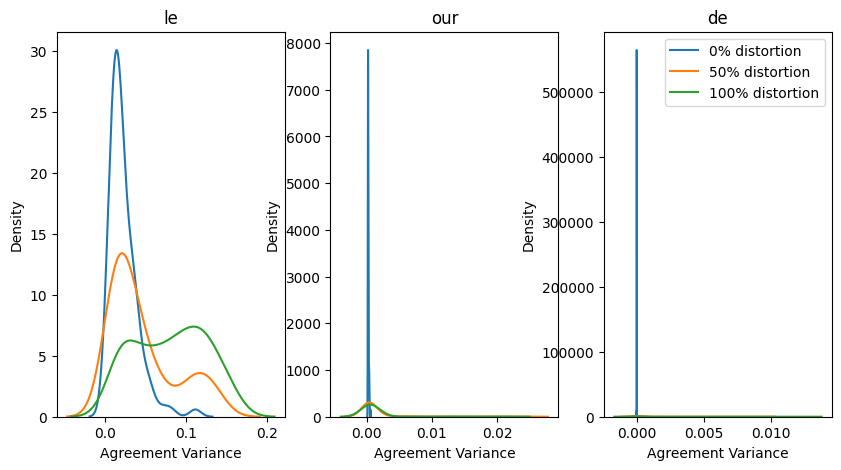

In [110]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
struct = 'disc'

for i, key in enumerate(models.keys()):
    sns.kdeplot(models[key][f'pd_{struct}'], label='0% distortion', ax=ax[i])
    sns.kdeplot(models[key][f'pd_{struct}_50'], label='50% distortion', ax=ax[i])
    sns.kdeplot(models[key][f'pd_{struct}_100'], label='100% distortion', ax=ax[i])
    ax[i].set_title(key)
    ax[i].set_xlabel('Agreement Variance')

plt.legend()

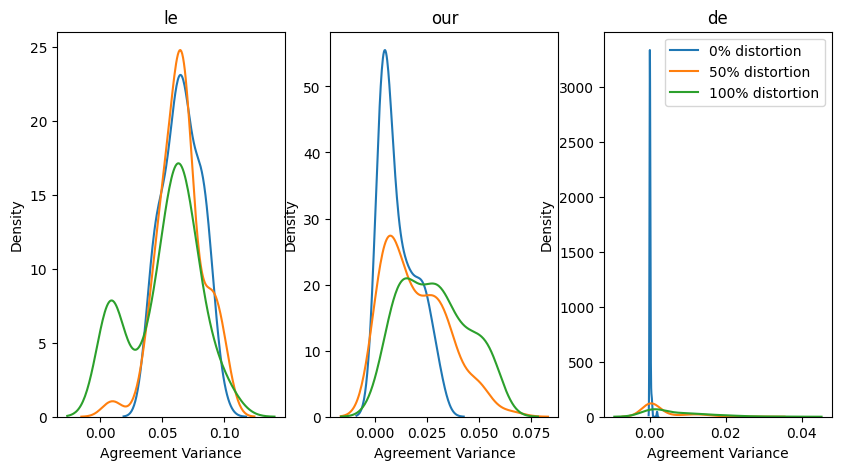

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(10, 5))
struct = 'cup'

for i, key in enumerate(models.keys()):
    sns.kdeplot(models[key][f'pd_{struct}'], label='0% distortion', ax=ax[i])
    sns.kdeplot(models[key][f'pd_{struct}_50'], label='50% distortion', ax=ax[i])
    sns.kdeplot(models[key][f'pd_{struct}_100'], label='100% distortion', ax=ax[i])
    ax[i].set_title(key)
    ax[i].set_xlabel('Agreement Variance')

plt.legend()

In [112]:
for key in ['le', 'our']:
    val = models[key]
    skip_idx = None if key == 'le' else None
    disc_dices, cup_dices = get_model_outputs(args, val['model'], test_set, loss_func, skip_idx=skip_idx)
    models[key]['dices_pd'] = (disc_dices, cup_dices)

    disc_dices_50, cup_dices_50 = get_model_outputs(args, val['model'], test_set_50, loss_func, skip_idx=skip_idx)
    models[key]['dices_pd_50'] = (disc_dices_50, cup_dices_50)

    disc_dices_100, cup_dices_100 = get_model_outputs(args, val['model'], test_set_100, loss_func, skip_idx=skip_idx)
    models[key]['dices_pd_100'] = (disc_dices_100, cup_dices_100)

In [157]:
disc_threshold = 0.9
cup_threshold = 0.8

In [160]:
for key in ['le', 'our']:
    val = models[key]
    for dice_postfix in ['', '_50', '_100']:
        pd_disc = get_prediction_depths(val[f'dices_pd{dice_postfix}'][0], disc_threshold)
        models[key][f'pd2_disc{dice_postfix}'] = pd_disc

        pd_cup = get_prediction_depths(val[f'dices_pd{dice_postfix}'][1], cup_threshold)
        models[key][f'pd2_cup{dice_postfix}'] = pd_cup

Text(0, 0.5, 'count')

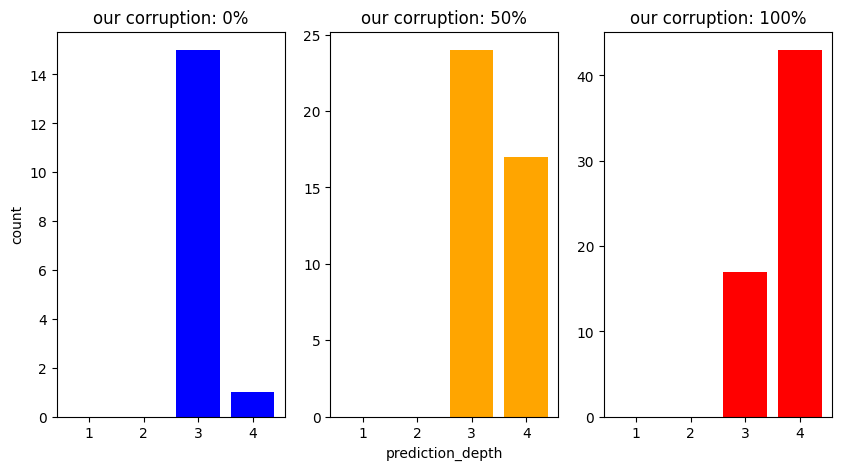

In [149]:
max_pd = 4
key = 'our'
struct = 'disc'

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

x = [i+1 for i in range(max_pd)]
counts = [models[key][f'pd2_{struct}'].count(value) for value in x]
counts_50 = [models[key][f'pd2_{struct}_50'].count(value) for value in x]
counts_100 = [models[key][f'pd2_{struct}_100'].count(value) for value in x]

axes[0].bar(x, counts, color='blue')
axes[0].set_title(f'{key} corruption: 0%')

axes[1].bar(x, counts_50, color='orange')
axes[1].set_title(f'{key} corruption: 50%')

axes[2].bar(x, counts_100, color='red')
axes[2].set_title(f'{key} corruption: 100%')

axes[1].set_xlabel('prediction_depth')
axes[0].set_ylabel('count')

Text(0, 0.5, 'count')

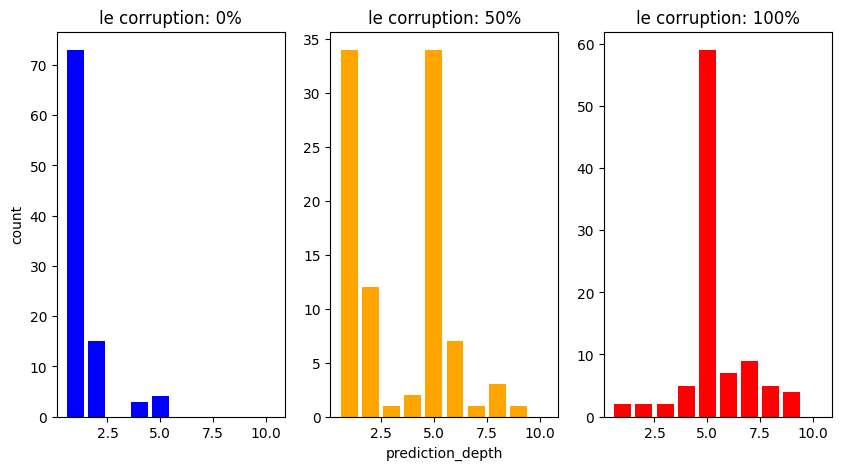

In [150]:
max_pd = 10
key = 'le'
struct = 'disc'

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

x = [i+1 for i in range(max_pd)]
counts = [models[key][f'pd2_{struct}'].count(value) for value in x]
counts_50 = [models[key][f'pd2_{struct}_50'].count(value) for value in x]
counts_100 = [models[key][f'pd2_{struct}_100'].count(value) for value in x]

axes[0].bar(x, counts, color='blue')
axes[0].set_title(f'{key} corruption: 0%')

axes[1].bar(x, counts_50, color='orange')
axes[1].set_title(f'{key} corruption: 50%')

axes[2].bar(x, counts_100, color='red')
axes[2].set_title(f'{key} corruption: 100%')

axes[1].set_xlabel('prediction_depth')
axes[0].set_ylabel('count')

Text(0, 0.5, 'count')

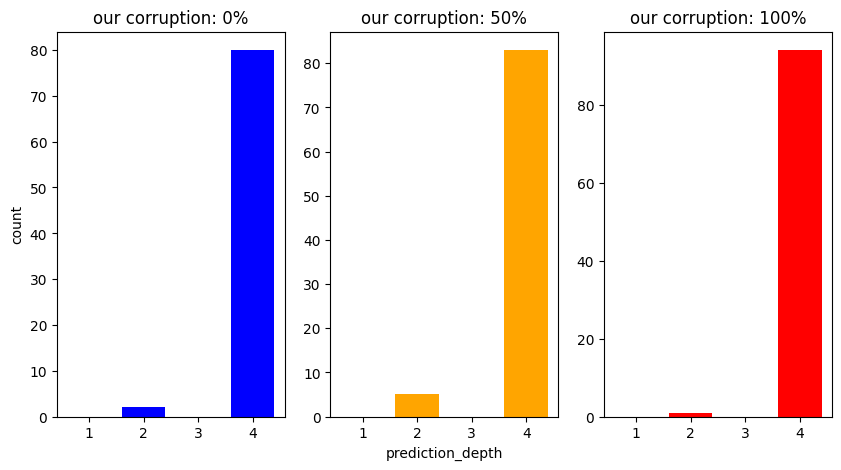

In [161]:
max_pd = 4
key = 'our'
struct = 'cup'

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

x = [i+1 for i in range(max_pd)]
counts = [models[key][f'pd2_{struct}'].count(value) for value in x]
counts_50 = [models[key][f'pd2_{struct}_50'].count(value) for value in x]
counts_100 = [models[key][f'pd2_{struct}_100'].count(value) for value in x]

axes[0].bar(x, counts, color='blue')
axes[0].set_title(f'{key} corruption: 0%')

axes[1].bar(x, counts_50, color='orange')
axes[1].set_title(f'{key} corruption: 50%')

axes[2].bar(x, counts_100, color='red')
axes[2].set_title(f'{key} corruption: 100%')

axes[1].set_xlabel('prediction_depth')
axes[0].set_ylabel('count')

Text(0, 0.5, 'count')

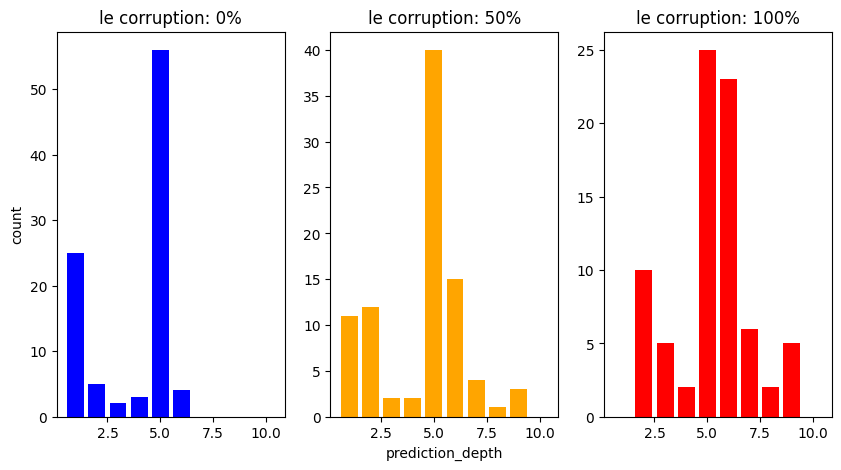

In [162]:
max_pd = 10
key = 'le'
struct = 'cup'

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

x = [i+1 for i in range(max_pd)]
counts = [models[key][f'pd2_{struct}'].count(value) for value in x]
counts_50 = [models[key][f'pd2_{struct}_50'].count(value) for value in x]
counts_100 = [models[key][f'pd2_{struct}_100'].count(value) for value in x]

axes[0].bar(x, counts, color='blue')
axes[0].set_title(f'{key} corruption: 0%')

axes[1].bar(x, counts_50, color='orange')
axes[1].set_title(f'{key} corruption: 50%')

axes[2].bar(x, counts_100, color='red')
axes[2].set_title(f'{key} corruption: 100%')

axes[1].set_xlabel('prediction_depth')
axes[0].set_ylabel('count')